# 1- Import libraries

In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
import numpy as np
import rasterio
import matplotlib.pyplot as plt

Shape File

In [2]:
shapefile_path = '../data/distritos/DISTRITOS.shp'
gdf = gpd.read_file(shapefile_path)

gdf.head()

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.31710 -9.297..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."


Raster

In [3]:
# Ruta al archivo
rasterfil_epath = '../data/tmin_raster.tif'

# Abrir el archivo
with rasterio.open(rasterfil_epath) as src:
    print("Ancho:", src.width)
    print("Alto:", src.height)
    print("Número de bandas:", src.count)
    print("Sistema de coordenadas:", src.crs)
    print("Transformación (afín):", src.transform)

    # bandas del raster
    banda1 = src.read(1)
    banda2 = src.read(2)
    banda3 = src.read(3)
    banda4 = src.read(4)
    banda5 = src.read(5)

Ancho: 285
Alto: 397
Número de bandas: 5
Sistema de coordenadas: EPSG:4326
Transformación (afín): | 0.05, 0.00,-81.38|
| 0.00,-0.05, 1.20|
| 0.00, 0.00, 1.00|


In [5]:
bandas = [banda1, banda2, banda3, banda4, banda5]

for i, banda in enumerate(bandas, start=1):
    print(f"=== Estadísticas Banda {i} ===")
    print(f"Mín: {np.nanmin(banda):.2f}")
    print(f"Máx: {np.nanmax(banda):.2f}")
    print(f"Media: {np.nanmean(banda):.2f}")



=== Estadísticas Banda 1 ===
Mín: -9.05
Máx: 24.64
Media: 18.01
=== Estadísticas Banda 2 ===
Mín: -10.02
Máx: 24.39
Media: 17.91
=== Estadísticas Banda 3 ===
Mín: -9.87
Máx: 24.21
Media: 17.77
=== Estadísticas Banda 4 ===
Mín: -9.06
Máx: 24.12
Media: 17.61
=== Estadísticas Banda 5 ===
Mín: -8.85
Máx: 24.15
Media: 17.82


In [ ]:
# Reproyectar shapefile (para que coincida con el raster)
with rasterio.open(rasterfil_epath) as src:
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Recortar el raster usando el shapefile
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

# Actualizar metadata para el nuevo raster recortado
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Guardar el nuevo raster recortado (opcional)
with rasterio.open("recorte.tif", "w", **out_meta) as dest:
    dest.write(out_image)

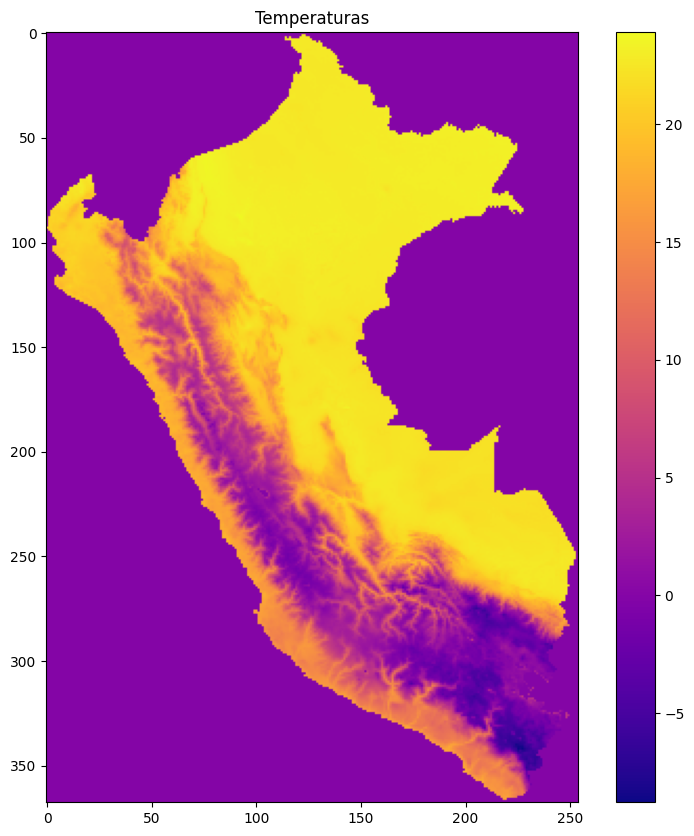

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(out_image[0], cmap='plasma')
plt.title("Temperaturas")
plt.colorbar()
plt.show()

Estadisticas por zona

In [12]:
# Métrica custom: rango (max - min)
def rango(values):
    arr = np.asarray(values, float)
    if np.ma.isMaskedArray(arr):
        arr = arr.compressed()
    else:
        arr = arr[~np.isnan(arr)]
    return np.max(arr) - np.min(arr) if arr.size else np.nan

# Escala del raster (si está en décimas de °C, usar 0.1) 
SCALE_FACTOR = 0.1   # cambia a 1.0 si ya está en °C

# Estadísticas zonales por banda 
metrics = ["count", "mean", "min", "max", "std", "percentile_10", "percentile_90"]
RASTER_PATH = "recorte.tif" 

for b in range(1, 6):
    stats_b = zonal_stats(
        gdf,
        RASTER_PATH,
        stats=metrics,
        band=b,
        add_stats={"rango": rango}
    )

    # Crear columnas y aplicar el factor de escala
    for met in metrics + ["rango"]:
        vals = np.array([s.get(met, np.nan) for s in stats_b], dtype=float)
        # Escalamos solo las métricas con unidades (no count)
        if met not in ["count"]:
            vals = vals * SCALE_FACTOR
        gdf[f"temp_b{b}_{met}"] = vals

# Promedio total entre las 5 bandas (para la media) 
gdf["temp_promedio_total"] = gdf[[f"temp_b{i}_mean" for i in range(1, 6)]].mean(axis=1)

# Estadísticas generales (promedio entre bandas)
for met in ["mean", "min", "max", "std", "percentile_10", "percentile_90", "rango"]:
    gdf[f"temp_{met}_general"] = gdf[[f"temp_b{i}_{met}" for i in range(1, 6)]].mean(axis=1)

# Count general (mejor suma que promedio)
gdf["temp_count_general"] = gdf[[f"temp_b{i}_count" for i in range(1, 6)]].sum(axis=1)

# Mostrar resumen general por distritos
cols = ["DISTRITO",
        "temp_mean_general", "temp_min_general", "temp_max_general",
        "temp_std_general", "temp_percentile_10_general", "temp_percentile_90_general",
        "temp_rango_general", "temp_count_general",
        "temp_promedio_total"]
print(gdf[cols].head())


                 DISTRITO  temp_mean_general  temp_min_general  \
0         CODO DEL POZUZO           1.876100          0.887002   
1             TOURNAVISTA           2.204822          1.956597   
2  ALEXANDER VON HUMBOLDT           2.186291          2.173003   
3                 IRAZOLA           2.209732          2.148695   
4                 NESHUYA           2.193790          2.172742   

   temp_max_general  temp_std_general  temp_percentile_10_general  \
0          2.240624          0.338942                    1.374314   
1          2.256262          0.045205                    2.176058   
2          2.194695          0.008088                    2.175621   
3          2.232286          0.015351                    2.189493   
4          2.218038          0.013344                    2.177117   

   temp_percentile_90_general  temp_rango_general  temp_count_general  \
0                    2.215663            1.542755               535.0   
1                    2.239254            0

Distribution: histogram of district-level mean Tmin.

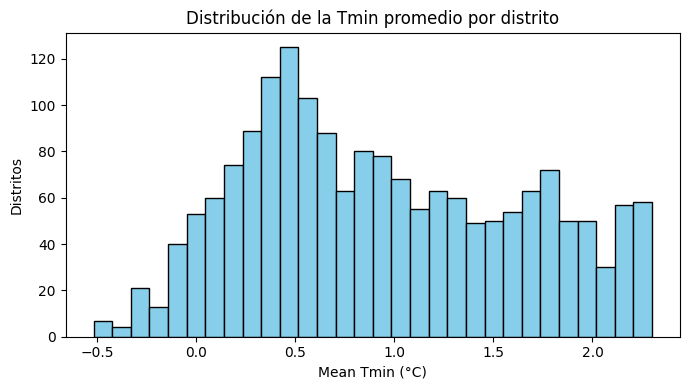

In [ ]:
import matplotlib.pyplot as plt

COL = "temp_promedio_total" 

plt.figure(figsize=(7, 4))
plt.hist(gdf[COL], bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Mean Tmin (°C)")
plt.ylabel("Distritos")
plt.title("Distribución de la Tmin promedio por distrito")
plt.tight_layout()
plt.savefig("../output/hist_tmin.png", dpi=300)
plt.show()
plt.close()

Ranking: Top 15 districts with lowest mean Tmin (frost risk) and top 15 highest.

In [ ]:
import pandas as pd

COL = "temp_promedio_total"

rank_df = gdf[["DISTRITO", COL]].copy()

top_cold = rank_df.nsmallest(15, COL).reset_index(drop=True)
top_hot  = rank_df.nlargest(15, COL).reset_index(drop=True)

# Guarda tablas 
top_cold.to_csv("../output/ranking_tmin_top15_cold.csv", index=False)
top_hot.to_csv("../output/ranking_tmin_top15_hot.csv", index=False)

rank_df_comb = pd.concat(
    [top_cold.assign(grupo="más fríos"), top_hot.assign(grupo="más cálidos")],
    ignore_index=True
)
rank_df_comb.to_csv("../output/ranking_tmin_top15_combined.csv", index=False)

print("\nTop 15 más fríos (Tmin baja):")
print(top_cold)

print("\nTop 15 más cálidos (Tmin alta):")
print(top_hot)



Top 15 más fríos (Tmin baja):
                DISTRITO  temp_promedio_total
0                 CAPAZO            -0.519107
1               SUSAPAYA            -0.515780
2                 TARATA            -0.499574
3             SANTA ROSA            -0.486188
4                 TICACO            -0.441739
5   SAN ANTONIO DE CHUCA            -0.439031
6              CANDARAVE            -0.435931
7              CONDOROMA            -0.412295
8                PARATIA            -0.409457
9                CARUMAS            -0.341197
10  SAN JUAN DE TARUCANI            -0.334318
11                  TUTI            -0.325812
12              PISACOMA            -0.324872
13               AJOYANI            -0.314103
14           SANTA LUCIA            -0.306395

Top 15 más cálidos (Tmin alta):
          DISTRITO  temp_promedio_total
0           MORONA             2.300898
1           YAGUAS             2.300503
2   RAMON CASTILLA             2.297255
3        SAN PABLO             2.293451


Map: static choropleth with GeoPandas

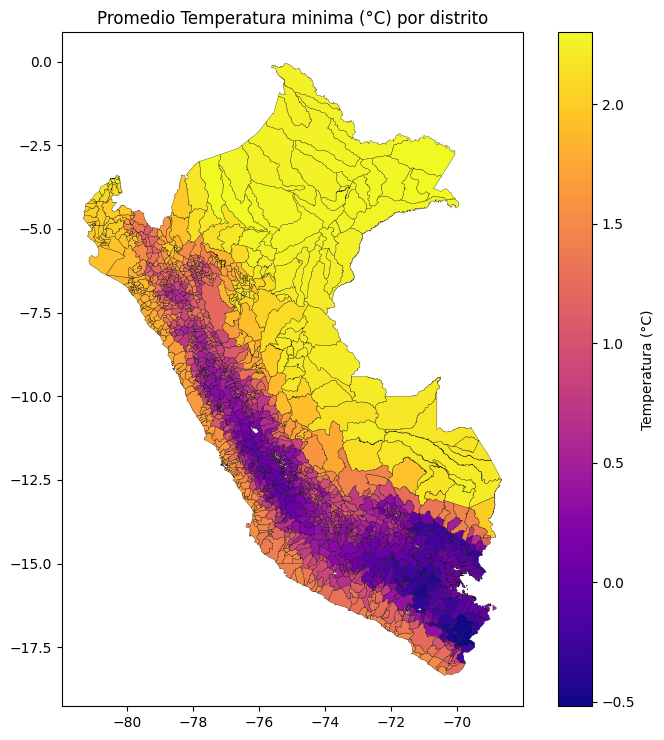

In [11]:
import matplotlib.pyplot as plt

COL = "temp_promedio_total"

fig, ax = plt.subplots(figsize=(7.5, 7.5))
gdf.plot(
    column=COL,
    legend=True,
    linewidth=0.2,
    edgecolor="black",
    ax=ax,
    legend_kwds={'label' : 'Temperatura (°C)'},
    cmap='plasma',
)
ax.set_title("Promedio Temperatura minima (°C) por distrito")
plt.tight_layout()
plt.savefig("../output/map_tmin_choropleth.png", dpi=300)
plt.show()
plt.close()
